# Análise Comercial e de Eventos
Este notebook explora dados de clientes, pedidos, vendas, faturas e vendedores,
com o objetivo de identificar padrões de receita, performance e engajamento.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
clientes_df = pd.read_csv('../dados/clientes.csv')
eventos_df = pd.read_csv('../dados/eventos.csv')
faturas_df = pd.read_csv('../dados/faturas.csv')
item_vendas_df = pd.read_csv('../dados/item_vendas.csv')
pedidos_df = pd.read_csv('../dados/pedidos.csv')
vendedores_df = pd.read_csv('../dados/vendedores.csv')

In [4]:
for nome, df in {
    "Clientes": clientes_df,
    "Eventos": eventos_df,
    "Faturas": faturas_df,
    "Pedidos": pedidos_df,
    "Vendas": item_vendas_df,
    "Vendedores": vendedores_df,
}.items():
    print(f"{nome}: {df.shape[0]} linhas, {df.shape[1]} colunas")


Clientes: 25000 linhas, 9 colunas
Eventos: 20 linhas, 10 colunas
Faturas: 80000 linhas, 7 colunas
Pedidos: 120000 linhas, 5 colunas
Vendas: 274780 linhas, 14 colunas
Vendedores: 200 linhas, 4 colunas


## 🧩 Receita mensal e taxa de crescimento

**Filtro:**  
`status_pedido = 'ganho'` e `status_pagamento = 'confirmado'`

**Base:**  
`item_vendas_df` *(colunas: valor_total, data_pagamento)*

---

### 🔍 Análises
- Receita total confirmada por mês  
- Crescimento percentual mês a mês  
- Identificação de meses de pico ou queda na performance  

---

### 📊 Gráficos
- **Painel A:** Linha da receita mensal (com pontos e grade para destacar variações)  
- **Painel B (opcional):** Linha da taxa de crescimento percentual por mês  

---

### 💬 Interpretação esperada
A análise mostra a **evolução do faturamento ao longo do tempo**, evidenciando sazonalidade, tendência e meses de maior conversão.  
Serve como ponto de partida para entender **ciclos de venda, impacto de eventos e períodos de alta demanda.**


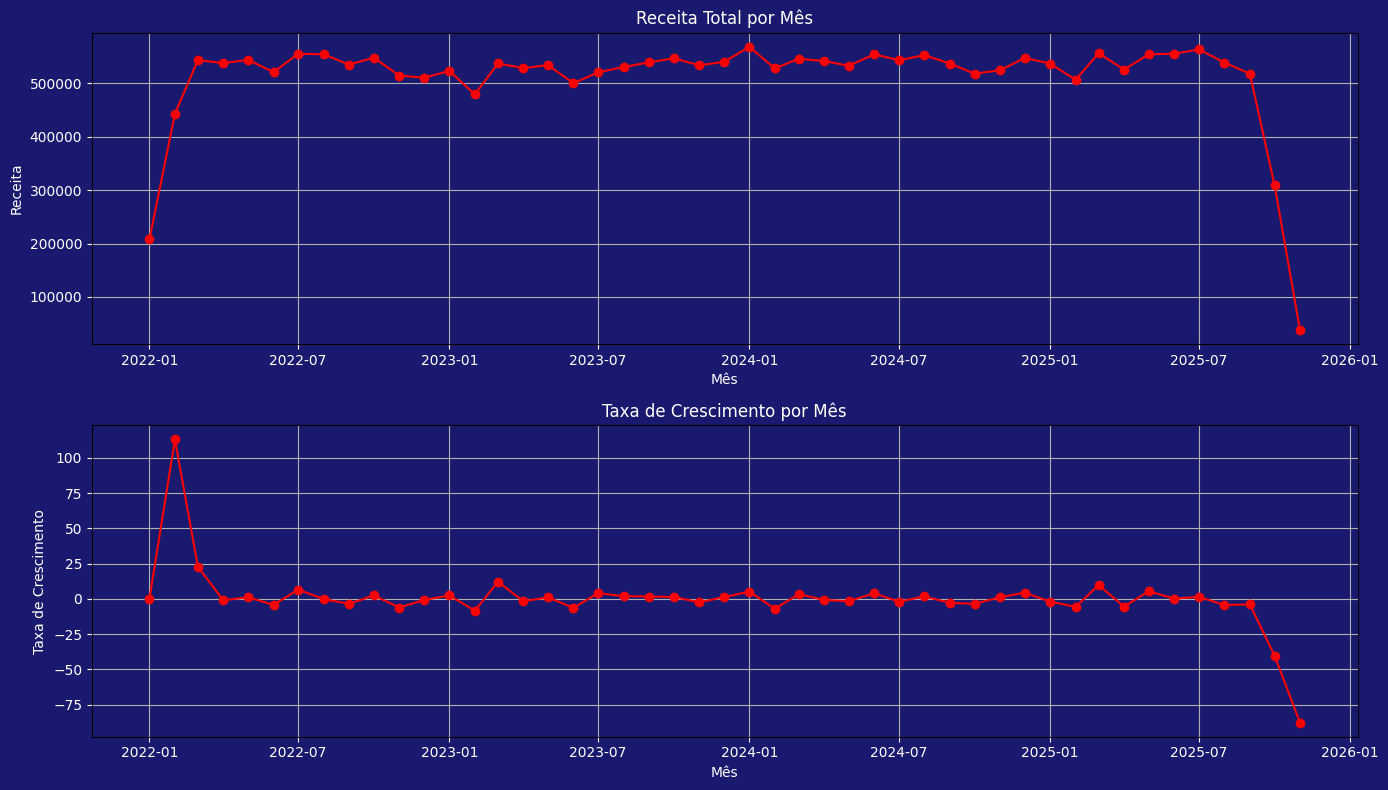

In [ ]:
"""Receita Mensal e Taxa de Crescimento"""

receita_mensal_e_taxa = (
    item_vendas_df[['data_pagamento', 'valor_total', 'id_pedido', 'status_pagamento']].merge(
    pedidos_df[['id_pedido', 'status_pedido']], on='id_pedido', how='inner')
)
receita_mensal_e_taxa['data_pagamento'] = pd.to_datetime(receita_mensal_e_taxa['data_pagamento'])

receita_mensal_e_taxa = (
    receita_mensal_e_taxa.loc[(receita_mensal_e_taxa['status_pagamento'] == 'confirmado') 
    & (receita_mensal_e_taxa['status_pedido'] == 'ganho')]
    .groupby(receita_mensal_e_taxa['data_pagamento'].dt.to_period('M'))['valor_total']
    .sum()
    .reset_index()
    .rename(columns={
        'data_pagamento': 'Período',
        'valor_total': 'Receita Mensal'
    })
)

receita_mensal_e_taxa['Taxa Crescimento'] = (
    receita_mensal_e_taxa['Receita Mensal'].pct_change().fillna(0) * 100
).round(2)

receita_mensal_e_taxa['Período'] = receita_mensal_e_taxa['Período'].dt.to_timestamp()

plt.rcParams['figure.facecolor'] = '#191970'
plt.rcParams['axes.facecolor'] = '#191970'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'


fig, ax = plt.subplots(2, figsize=(14,8))

ax[0].plot(
    receita_mensal_e_taxa['Período'],
    receita_mensal_e_taxa['Receita Mensal'],
    color='red',
    marker='o'
)

ax[0].set_title('Receita Total por Mês')
ax[0].set_xlabel('Mês')
ax[0].set_ylabel('Receita')
ax[0].grid()


ax[1].plot(
    receita_mensal_e_taxa['Período'],
    receita_mensal_e_taxa['Taxa Crescimento'],
    color='red',
    marker='o'
)

ax[1].set_title('Taxa de Crescimento por Mês')
ax[1].set_xlabel('Mês')
ax[1].set_ylabel('Taxa de Crescimento')
ax[1].grid()

plt.tight_layout()
plt.show()


## 🧩 Ticket médio por cliente e por pedido

**Filtro:**  
`status_pedido = 'ganho'` e `status_pagamento = 'confirmado'`

**Base:**  
`item_vendas_df` *(colunas: id_cliente, id_pedido, valor_total)*

---

### 🔍 Análises
- Calcular a **receita total confirmada** por cliente.  
- Calcular o **ticket médio por cliente** (`receita / nº de pedidos`).  
- Calcular o **ticket médio por pedido** (`valor_total médio por pedido`).  
- Comparar os dois resultados para entender o comportamento de compra.

---

### 📊 Gráficos
- **Painel A:** Barras comparando o ticket médio por cliente e por pedido.  
- **Painel B (opcional):** Distribuição do ticket médio por cliente (histograma).  

---

### 💬 Interpretação esperada
Esta análise identifica **quanto cada cliente gasta em média** e **quanto vale cada pedido**.  
Ajuda a entender o perfil de consumo, detectar **clientes de alto valor**, e avaliar **oportunidades de aumento de ticket** por meio de ofertas, upsell ou personalização.


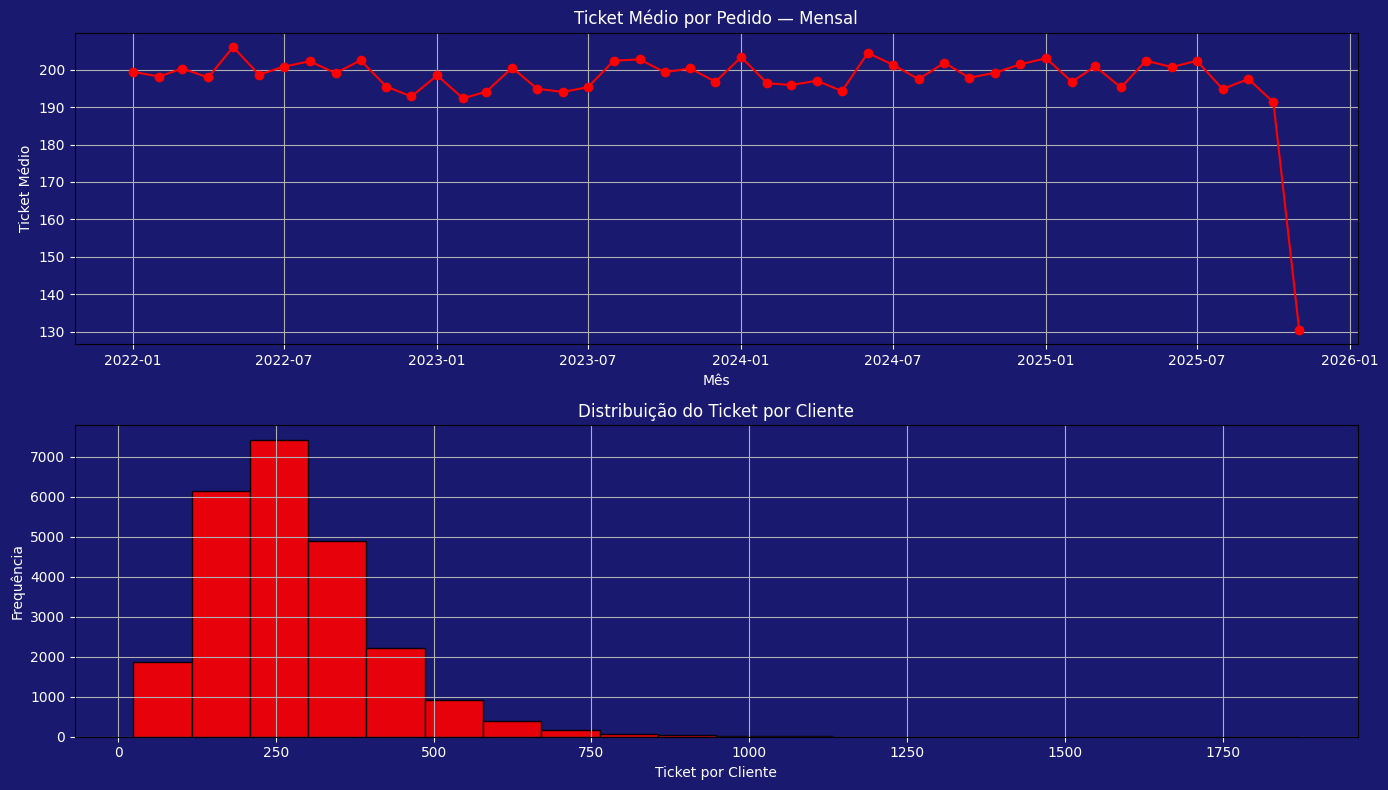

In [75]:
"""Ticket Médio por Cliente e por Pedido"""

ticket_medio = (
    item_vendas_df[['id_pedido', 'valor_total', 'data_pagamento', 'status_pagamento']].merge(
    pedidos_df[['id_pedido', 'id_cliente', 'status_pedido']], on='id_pedido', how='inner')
)

ticket_medio['data_pagamento'] = pd.to_datetime(ticket_medio['data_pagamento'])

ticket_medio = (
    ticket_medio.loc[(ticket_medio['status_pagamento'] == 'confirmado') 
    & (ticket_medio['status_pedido'] == 'ganho')]
)

ticket_pedido = (
    ticket_medio.groupby([ticket_medio['data_pagamento'].dt.to_period('M'), 'id_pedido'])['valor_total']
    .sum()
    .reset_index()
    .groupby('data_pagamento')['valor_total']
    .mean()
    .reset_index()
    .rename(columns={
        'data_pagamento': 'Período',
        'valor_total': 'Ticket Médio Pedido'
    })
)

ticket_pedido['Período'] = ticket_pedido['Período'].dt.to_timestamp()

ticket_cliente = (
    ticket_medio.groupby('id_cliente')
    .agg({'valor_total':'sum','id_pedido':'nunique'})
    .reset_index()
    .rename(columns={'valor_total':'Receita Cliente','id_pedido':'Qtd Pedidos'})
)

ticket_cliente['Ticket Cliente'] = ticket_cliente['Receita Cliente'] / ticket_cliente['Qtd Pedidos']

plt.rcParams['figure.facecolor'] = '#191970'
plt.rcParams['axes.facecolor'] = '#191970'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'

fig, ax = plt.subplots(2, figsize=(14,8))

ax[0].plot(
    ticket_pedido['Período'],
    ticket_pedido['Ticket Médio Pedido'],
    color='red',
    marker='o'
)

ax[0].set_title('Ticket Médio por Pedido — Mensal')
ax[0].set_xlabel('Mês')
ax[0].set_ylabel('Ticket Médio')
ax[0].grid()

ax[1].hist(
    ticket_cliente['Ticket Cliente'],
    bins=20,
    color='red',
    alpha=0.9,
    edgecolor='black'
)

ax[1].set_title('Distribuição do Ticket por Cliente')
ax[1].set_xlabel('Ticket por Cliente')
ax[1].set_ylabel('Frequência')
ax[1].grid()

plt.tight_layout()
plt.show()

## 🧩 Receita por equipe e por região

**Filtro:**  
`status_pedido = 'ganho'` e `status_pagamento = 'confirmado'`

**Base:**  
`item_vendas_df` *(id_pedido, valor_total, status_pagamento)*  
`pedidos_df` *(id_pedido, id_vendedor, status_pedido)*  
`vendedores_df` *(id_vendedor, equipe, regiao)*

---

### 🔍 Análises
- Receita total confirmada por **equipe**  
- Receita total confirmada por **região**

---

### 📊 Gráficos
- **Painel A:** Barras verticais mostrando a receita total por equipe  
- **Painel B:** Barras horizontais da receita por região 

---

### 💬 Interpretação esperada
Visualiza o desempenho das **equipes de vendas** e das **regiões geográficas**, facilitando a leitura das diferenças de receita com uma escala numérica clara e direta.  
Esse formato evidencia tanto o peso relativo das equipes quanto o comportamento por área geográfica, ajudando a direcionar esforços de expansão ou reforço comercial.


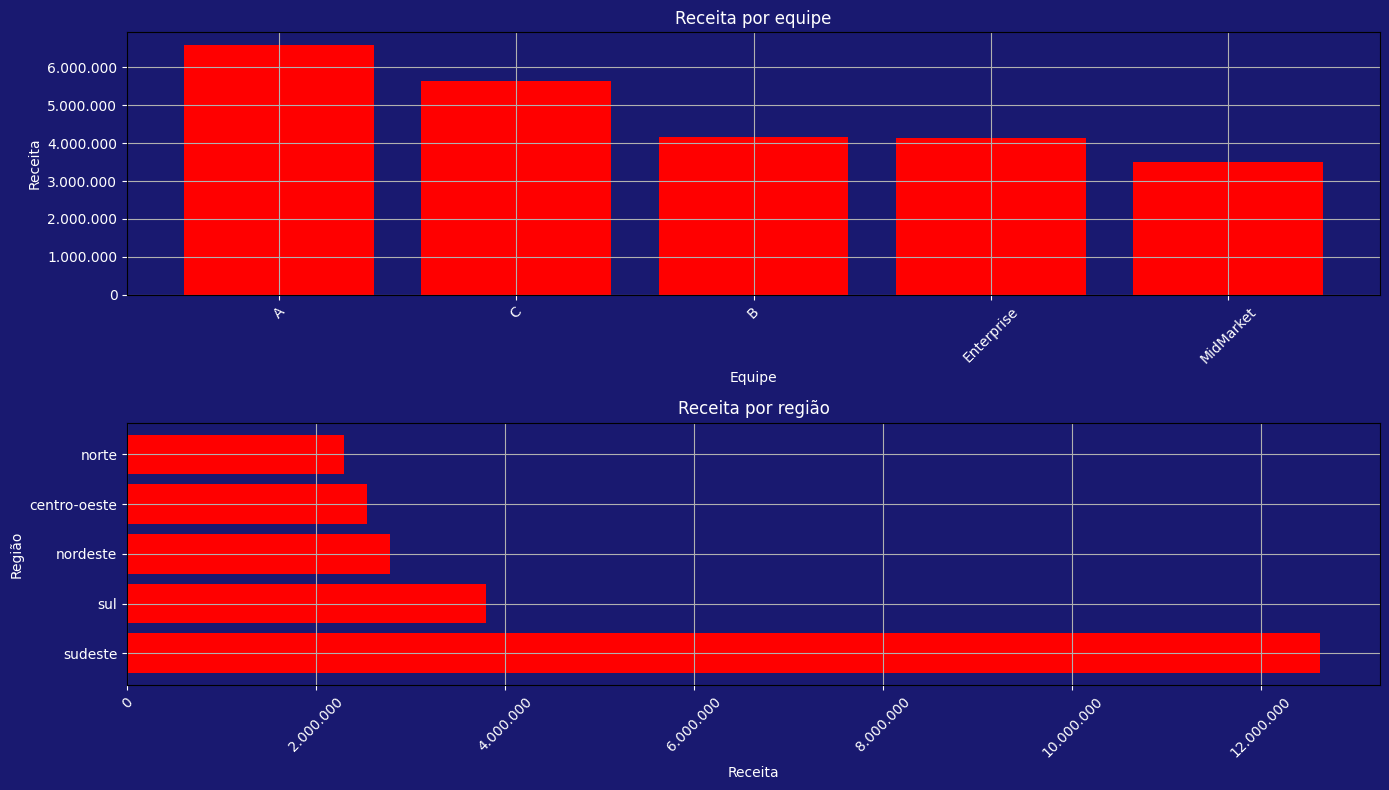

In [80]:
"""3) Receita por equipe e por região (barras)"""
from matplotlib.ticker import FuncFormatter


receita_team_region = (
    item_vendas_df[['id_pedido', 'valor_total', 'status_pagamento']].merge(
    pedidos_df[['id_pedido', 'id_vendedor', 'status_pedido']], on='id_pedido', how='inner').merge(
    vendedores_df[['id_vendedor', 'equipe', 'regiao']], on='id_vendedor', how='left')
)

receita_team_region = (
    receita_team_region.loc[(receita_team_region['status_pagamento'] == 'confirmado')
    & (receita_team_region['status_pedido'] == 'ganho')]
)

receita_por_equipe = (
    receita_team_region.groupby('equipe')['valor_total']
    .sum()
    .reset_index()
    .rename(columns={'valor_total': 'Receita'})
    .sort_values('Receita', ascending=False)
)

receita_por_regiao = (
    receita_team_region.groupby('regiao')['valor_total']
    .sum()
    .reset_index()
    .rename(columns={'valor_total': 'Receita'})
    .sort_values('Receita', ascending=False)
)

plt.rcParams['figure.facecolor'] = '#191970'
plt.rcParams['axes.facecolor'] = '#191970'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'

fig, ax = plt.subplots(2, figsize=(14,8))

formatador = FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.'))


ax[0].bar(
    receita_por_equipe['equipe'],
    receita_por_equipe['Receita'],
    color='red'
)
ax[0].set_title('Receita por equipe')
ax[0].set_xlabel('Equipe')
ax[0].set_ylabel('Receita')
ax[0].grid()
ax[0].tick_params(axis='x', rotation=45)
ax[0].ticklabel_format(style='plain', axis='y')
fmt_br = FuncFormatter(lambda x, pos: f'{x:,.0f}'.replace(',', '.'))
ax[0].yaxis.set_major_formatter(fmt_br)

ax[1].barh(
    receita_por_regiao['regiao'],
    receita_por_regiao['Receita'],
    color='red'
)
ax[1].set_title('Receita por região')
ax[1].set_xlabel('Receita')
ax[1].set_ylabel('Região')
ax[1].grid()
ax[1].tick_params(axis='x', rotation=45)
ax[1].ticklabel_format(style='plain', axis='x')
ax[1].xaxis.set_major_formatter(fmt_br)

plt.tight_layout()
plt.show()
